# Load Packages

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor


# Load Data

In [18]:
data = pd.read_csv("../Data/processed/training_full_with_extra_features.csv", sep="\t")
X = data.drop(columns=["ActualTOW"])
y = data["ActualTOW"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_features = X.select_dtypes(include=["number"]).columns.tolist()
cat_features = X.select_dtypes(exclude=["number"]).columns.tolist()

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

# Load Models

In [19]:
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
xgb = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.2, random_state=42)


In [20]:
models = {
    "Linear Regression": (lr, {}),
    "Decision Tree": (
        DecisionTreeRegressor(random_state=42),
        {
            "regressor__max_depth": [10],
            "regressor__min_samples_split": [2],
            "regressor__min_samples_leaf": [1]
        }
    ),
    "Random Forest": (
        rf,
        {
            "regressor__n_estimators": [200],
            "regressor__max_depth": [20],
            "regressor__min_samples_split": [2],
            "regressor__min_samples_leaf": [1]
        }
    ),
    "XGBoost": (
        xgb,
        {
            "regressor__n_estimators": [200],
            "regressor__max_depth": [6],
            "regressor__learning_rate": [0.2]
        }
    ),
    "Voting Regressor": (
        VotingRegressor([
            ("lr", lr),
            ("rf", rf),
            ("xgb", xgb)
        ]),
        {}
    ),
    "Stacking (Linear Regression final)": (
        StackingRegressor(
            estimators=[("lr", lr), ("rf", rf), ("xgb", xgb)],
            final_estimator=LinearRegression(),
            cv=5
        ),
        {}
    ),
}

# Train

In [21]:
results = []

for name, (model, param_grid) in models.items():
    print(f"Training: {name}")
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])

    if param_grid:
        grid = GridSearchCV(pipe, param_grid, scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        best_params = grid.best_params_
    else:
        pipe.fit(X_train, y_train)
        best_model = pipe
        best_params = "default"

    y_pred = best_model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    results.append({
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "Best Parameters": best_params
    })

Training: Linear Regression
Training: Decision Tree
Training: Random Forest
Training: XGBoost
Training: Voting Regressor
Training: Stacking (Linear Regression final)


# Result Table 

In [22]:
results_df = pd.DataFrame(results)
print(results_df)

                                Model         RMSE         MAE  \
0                   Linear Regression   932.315093  675.723827   
1                       Decision Tree  1017.021733  738.664626   
2                       Random Forest   925.681998  685.763134   
3                             XGBoost   926.229810  675.746508   
4                    Voting Regressor   897.489784  662.069401   
5  Stacking (Linear Regression final)   904.225304  666.871342   

                                     Best Parameters  
0                                            default  
1  {'regressor__max_depth': 10, 'regressor__min_s...  
2  {'regressor__max_depth': 20, 'regressor__min_s...  
3  {'regressor__learning_rate': 0.2, 'regressor__...  
4                                            default  
5                                            default  


# RMSE plot

C:\Users\huber\AppData\Local\Temp\ipykernel_14840\4290069499.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="RMSE", palette="viridis")


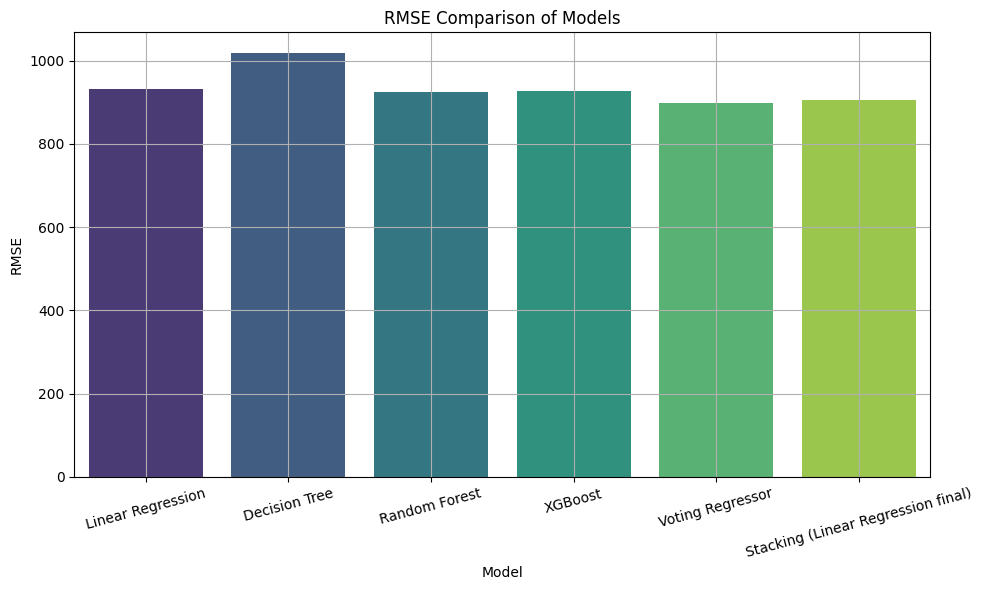

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x="Model", y="RMSE", palette="viridis")
plt.title("RMSE Comparison of Models")
plt.ylabel("RMSE")
plt.xticks(rotation=15)
plt.grid(True)
plt.tight_layout()
plt.show()

# MAE plot

C:\Users\huber\AppData\Local\Temp\ipykernel_14840\11255456.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="MAE", palette="magma")


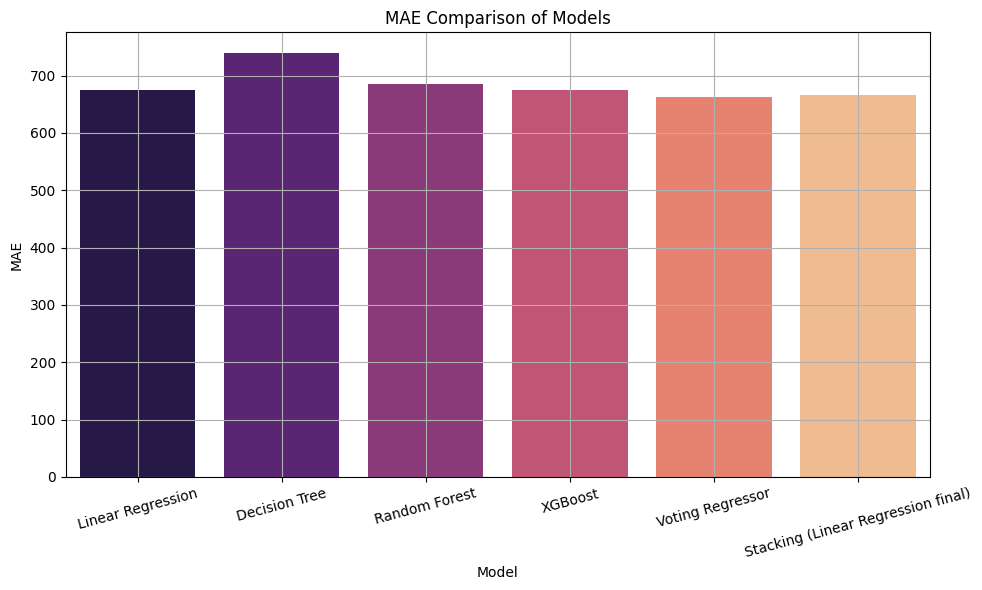

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x="Model", y="MAE", palette="magma")
plt.title("MAE Comparison of Models")
plt.ylabel("MAE")
plt.xticks(rotation=15)
plt.grid(True)
plt.tight_layout()
plt.show()